# Анализ пользовательского поведения в мобильном приложении

<h1>Содержание:<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Изучение-и-проверка-данных" data-toc-modified-id="Изучение-и-проверка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Изучение и проверка данных</a></span></li><li><span><a href="#Изучение-воронки-событий" data-toc-modified-id="Изучение-воронки-событий-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Изучение воронки событий</a></span></li><li><span><a href="#Изучение-результатов-эксперимента" data-toc-modified-id="Изучение-результатов-эксперимента-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Изучение результатов эксперимента</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

**Задачи проекта** 
- На основе данных использования мобильного приложения для продажи продуктов питания проанализировать воронку продаж, знать, сколько пользователей доходит до покупки, как они доходят до покупки и на каких шагах происходит "застревание". 
- оценить результаты A/A/B-тестирования по изменению шрифтов в приложении. Для этой цели пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Необходимо выяснить, какой шрифт лучше.

Таким образом исследование пройдет в пять этапов:

- Обзор данных;
- Предобработка данных;
- Изучение и проверка данных;
- Изучение воронки событий;
- Изучение результатов эксперимента.

## Обзор данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import numpy as np
import math as mth
from scipy import stats as st
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.float_format', '{:,.2f}'.format)

Загрузим и изучим данные. Сохраним в переменную `df`

In [2]:
df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [3]:
def info (df):
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.float_format', '{:,.2f}'.format)
    display(df.head(5))
    print(f'В таблице строк: {df.shape[0]}, столбцов: {df.shape[1]} ')
    print('Количество дубликатов:', df.duplicated().sum())
    print('Процент дубликатов: ', "{:.2%}".format((df.duplicated().sum()/df.shape[0])))
    tbl = pd.concat([df.dtypes, df.isna().sum(), round((df.isna().mean()*100),2), ], axis=1, 
                   keys=["Тип данных", "Кол-во пропусков", "% пропусков", ])
    display(tbl)

info(df)
 

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


В таблице строк: 244126, столбцов: 4 
Количество дубликатов: 413
Процент дубликатов:  0.17%


,Тип данных,Кол-во пропусков,% пропусков
EventName,object,0,0.00
DeviceIDHash,int64,0,0.00
EventTimestamp,int64,0,0.00
ExpId,int64,0,0.00


**Описание данных**

Каждая запись в логе — это действие пользователя, или событие.
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

**Вывод**

В исследуемом датасете достаточно наблюдений для анализа. Пропущенных значений не обнаружено. Обнаружены дубликаты и несоответствие типов данных. Названия столбцов не информативны, лучше их переименовать.
Для дальнейшего анализа необходимо провести предобработку данных. 

## Предобработка данных

Избавимся от дубликатов

In [4]:
df = df.drop_duplicates()
df.duplicated().sum()

0

Переименуем столбцы

In [5]:
df.columns = ['event_name', 'user_id', 'datetime', 'group']
df.head()

,event_name,user_id,datetime,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Приведем тип данных в колонке `datetime` к типу datetime

In [6]:
df['datetime'] = pd.to_datetime(df['datetime'], unit='s')
df.head()

,event_name,user_id,datetime,group
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


Добавим отдельный столбец с датой

In [7]:
df['date'] = pd.to_datetime(df['datetime']).dt.date
df.head()

,event_name,user_id,datetime,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [8]:
df['date'] = df['date'].astype('datetime64[ns]')

Заменим числовые обозначения групп на более понятные буквенные: A1 (246), A2 (247) и B (248)

In [9]:
df = df.replace({'group' : {246:'A1', 247: 'A2', 248:'B'}})
df.head()

,event_name,user_id,datetime,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,A1,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,A1,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,B,2019-07-25


**Вывод**

Мы преобразовали тип данных столбца с датой и временнем, выделили отдельно дату, дали столбцам более понятные названия. 
Данные готовы для дальнейшего анализа.

## Изучение и проверка данных


Найдем среднее количество событий (наблюдений) на одного пользователя и посмотрим на характер распределения событий.

,user_id,event_name
0,6304868067479728361,2307
1,197027893265565660,1998
2,4623191541214045580,1768
3,6932517045703054087,1439
4,1754140665440434215,1221


,event_name
count,"7,551.00"
mean,32.28
std,65.15
min,1.00
25%,9.00
50%,20.00
75%,37.00
max,"2,307.00"


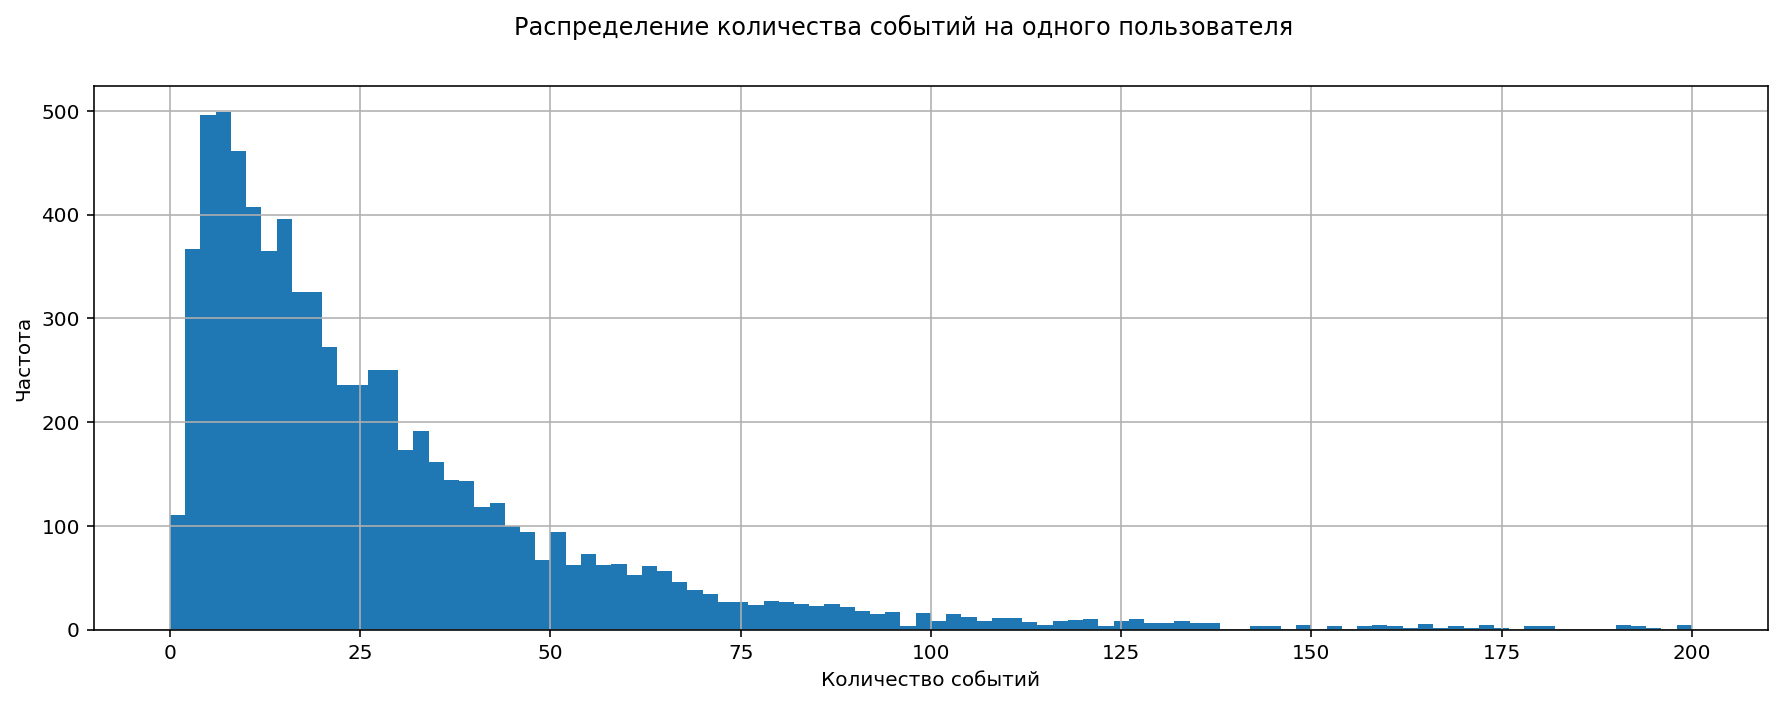

In [10]:
event_by_user = df.groupby(['user_id']).agg({'event_name':'count'}).sort_values(by='event_name', ascending=False).reset_index()
display(event_by_user.head())
display(event_by_user['event_name'].describe().to_frame())
event_by_user['event_name'].hist(bins=100, range=(0,200), figsize=(15, 5))
plt.suptitle('Распределение количества событий на одного пользователя')
plt.ylabel('Частота')
plt.xlabel('Количество событий');

In [11]:
event_by_user['event_name'].quantile(0.95)

89.0

Показатели среднего и медианы значительно отличаются. Медианное значение - 20 событий на пользователя, среднее значение - 32 события на пользователя. На графике и по числовым данным видим наличие выбросов, которые влияют на результат.  95% пользователей совершает не более 90 действий, выбросы достигают значения в 2,307 событий.

Определим данными за какой период мы располагаем. Найдем максимальную и минимальную дату. 

In [12]:
print("Начало наблюдений: ", df['date'].dt.date.min())
print("Окончание наблюдений: ", df['date'].dt.date.max())


Начало наблюдений:  2019-07-25
Окончание наблюдений:  2019-08-07


В нашем распоряжении логи за 14 дней, с 25 июля по 7 августа 2019 года.

Построим гистограмму распределения данных по дате и времени. Проверим, что у нас одинаково полные данные за весь период наблюдений.

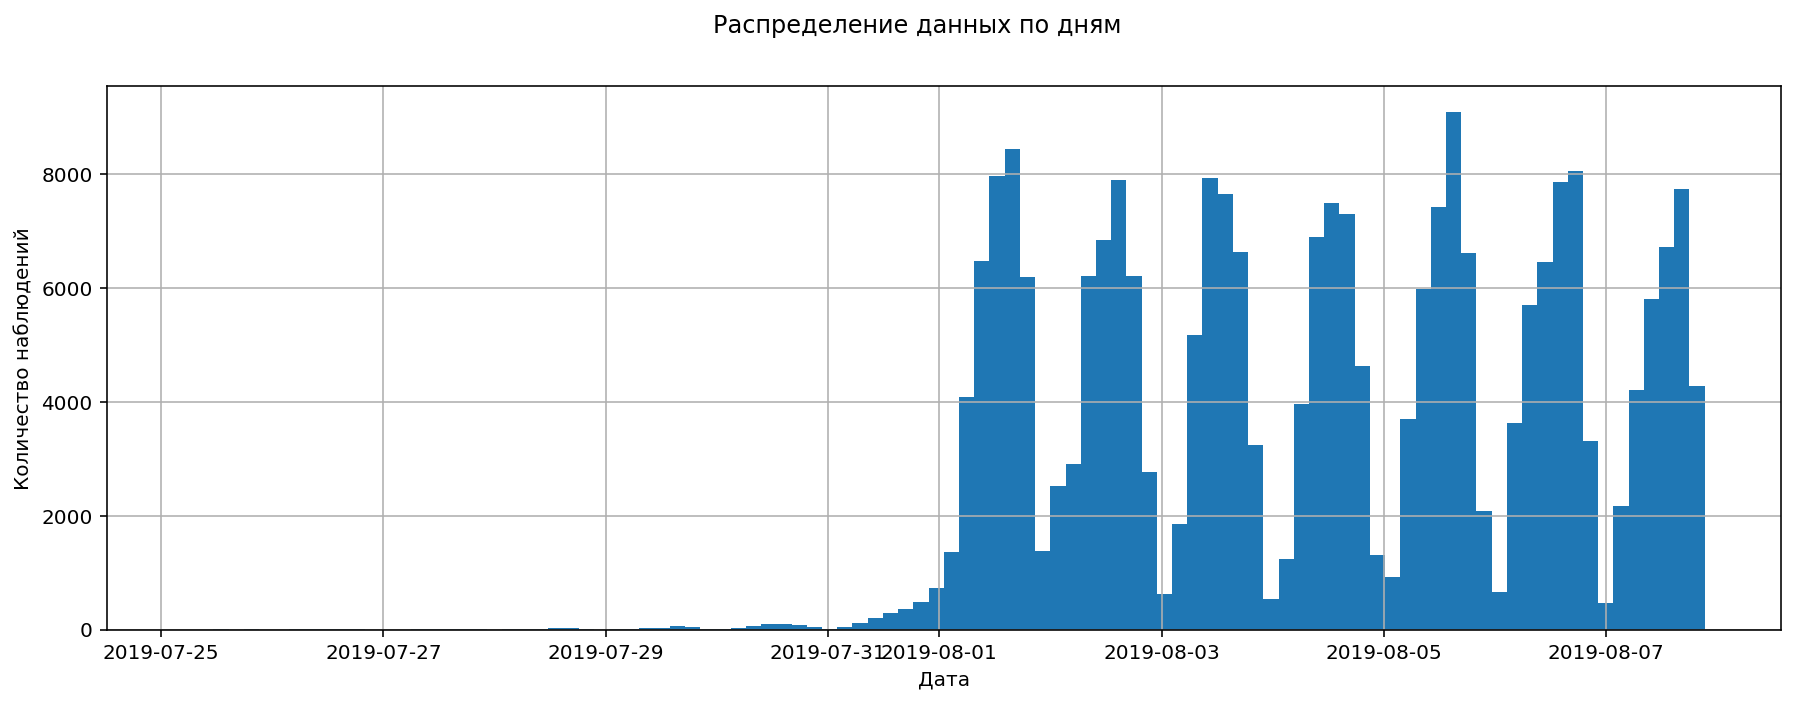

In [13]:
df['datetime'].hist(bins=100, figsize=(15, 5))
plt.suptitle('Распределение данных по дням')
plt.ylabel('Количество наблюдений')
plt.xlabel('Дата');

По графиу видно, что данные до 1 августа практически отсутствуют. В таком случае, логично использовать только данные за последние 7 дней.  Отбросим данные за период с 2019-07-25 по 2019-07-31 включительно.

In [14]:
df_7days = df.query('date > "2019-7-31"').reset_index(drop=True)
df_7days.head()

,event_name,user_id,datetime,group,date
0,Tutorial,3737462046622621720,2019-08-01 00:07:28,A1,2019-08-01
1,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,A1,2019-08-01
2,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,A1,2019-08-01
3,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,A1,2019-08-01
4,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,A2,2019-08-01


Посмотрим, сколько событий и пользователей мы потеряли, отбросив старые данные.

In [15]:
print('Количество событий после фильтрации: ', len(df_7days))

Количество событий после фильтрации:  240887


In [16]:
print(f'Количество удаленных наблюдений: {len(df) - len(df_7days)}, \
процент от общего: {round(100-len(df_7days)/len(df)*100, 2)} ')

Количество удаленных наблюдений: 2826, процент от общего: 1.16 


In [17]:
print(f'Количество удаленных пользователей: {df["user_id"].nunique() - df_7days["user_id"].nunique()}, \
процент от общего: {round(100-df_7days["user_id"].nunique()/df["user_id"].nunique()*100, 2)} ')

Количество удаленных пользователей: 17, процент от общего: 0.23 


Убедимся, что у нас есть пользователи из всех трёх экспериментальных групп.

In [18]:
df_7days.groupby('group')['user_id'].nunique().to_frame()

,user_id
group,
A1,2484
A2,2513
B,2537


**Вывод**

В ходе проверки данных мы обнаружили, что в период первых 7 дней данные практически отсутствуют. Мы исключили эти даты из таблицы. После фильтрации количество наблюдений сократилось на 1%, а пользователей стало меньше всего на 17 человек, что не является существенной потерей. 

## Изучение воронки событий

Посмотрим, какие события есть в логах, как часто они встречаются.

In [19]:
df_7days['event_name'].value_counts().to_frame()

,event_name
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


В базе содержатся 5 возможных событий:
- MainScreenAppear - просмотр главной страницы
- OffersScreenAppear - просмотр экрана с предложениями
- CartScreenAppear - просмотр экрана корзины
- PaymentScreenSuccessful - просмотр страницы успешной оплаты
- Tutorial - просмотр страницы туториала

Посчитаем, сколько пользователей совершали каждое из этих событий и долю пользователей, которые хоть раз совершали событие.

In [20]:
events = pd.concat([df_7days['event_name'].value_counts(),
          df_7days.groupby('event_name')['user_id'].nunique(), 
          df_7days.groupby('event_name')['user_id'].nunique() / df_7days['user_id'].nunique() *100,], 
          axis=1, 
          keys=["count", "users", "% "],)
events

,count,users,%
MainScreenAppear,117328,7419,98.47
OffersScreenAppear,46333,4593,60.96
CartScreenAppear,42303,3734,49.56
PaymentScreenSuccessful,33918,3539,46.97
Tutorial,1005,840,11.15


Оказалось, что около 2% пользователей не просматривали главную страницу. Меньше всего пользователей (11%) просматривали руководство, а на страницу успешной оплаты попало чуть меньше половины пользователей (48%).

Можно предположить, что воронка строится следующим образом: 
`MainScreenAppear` → `Tutorial` → `OffersScreenAppear` → `CartScreenAppear` → `PaymentScreenSuccessful`

Событие `Tutorial` не является значимой частью воронки, от этого действия не зависят другие и пользователь может зайти или не зайти на страницу туториала по своему желанию. При расчетах мы не будем учитывать событие `Tutorial`.

Отфильтруем данные, сохраним новую таблицу в переменную `funnel`

In [21]:
funnel = df_7days[df_7days['event_name'] != 'Tutorial']
funnel.head()

,event_name,user_id,datetime,group,date
1,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,A1,2019-08-01
2,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,A1,2019-08-01
3,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,A1,2019-08-01
4,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,A2,2019-08-01
5,MainScreenAppear,4899590676214355127,2019-08-01 00:10:15,A2,2019-08-01


Создадим воронку событий и посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).

In [22]:
funnel.groupby('event_name')['user_id'].nunique().sort_values(ascending=False)

event_name
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Name: user_id, dtype: int64

Создадим график воронки событий, в котором будут отражены отношения долей пользователей между шагами и к общему количеству.

In [23]:
stages = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']
fig = go.Figure(go.Funnel(
    y = stages,
    x = funnel.groupby('event_name')['user_id'].nunique().sort_values(ascending=False),
    textinfo = "value+percent previous"))
fig.update_layout(title="Воронка событий с расчетом кол-ва пользователей и отношением кол-ва пользователей между шагами")
fig.show()



Посмотрим, все ли пользователи, совершившие последнее действие, совершали все предыдущие.

In [24]:
MainScreenAppear = set(funnel[funnel['event_name'] == 'MainScreenAppear']['user_id'].unique())
OffersScreenAppear = set(funnel[funnel['event_name'] == 'OffersScreenAppear']['user_id'].unique())
CartScreenAppear = set(funnel[funnel['event_name'] == 'CartScreenAppear']['user_id'].unique())
PaymentScreenSuccessful = set(funnel[funnel['event_name'] == 'PaymentScreenSuccessful']['user_id'].unique())

len(PaymentScreenSuccessful.intersection(MainScreenAppear, OffersScreenAppear, CartScreenAppear))

3429

Исходя из расчетов, воронка продаж не строгая, т.к. из 3539 пользователей, учтенных в последнем шаге, только 3429 прошли также все другие шаги. Таким образом, 110 пользователей пропускали некоторые шаги воронки до совершения оплаты. Выпадение части пользователей характерно и для сравнения по другим шагам воронки.

**Вывод**

Судя по графику, на втором шаге теряется больше всего пользователей. До просмотра предложений доходит 62%. Число тех, кто перешел от предложений в корзину - 81%. Успешно оплачивают заказ около 95% из тех, кто начинал его оформление.

От первого события до оплаты доходит 47.7% пользователей.

## Изучение результатов эксперимента

Посмотрим, сколько уникальных пользователей в каждой экспериментальной группе.

In [25]:
funnel.groupby('group')['user_id'].nunique()

group
A1    2483
A2    2512
B     2535
Name: user_id, dtype: int64

In [26]:
print('Разница в количестве пользователей между группами А1 и А2: ', 
      "{:.2%}".format(funnel.query('group == "A2"')['user_id'].nunique() 
                      / funnel.query('group == "A1"')['user_id'].nunique() - 1))
print('Разница в количестве пользователей между группами А2 и В: ', 
      "{:.2%}".format(funnel.query('group == "B"')['user_id'].nunique() 
                      / funnel.query('group == "A2"')['user_id'].nunique() - 1))

Разница в количестве пользователей между группами А1 и А2:  1.17%
Разница в количестве пользователей между группами А2 и В:  0.92%


Проверим, есть ли пользователи, которые случайно попали в несколько групп

In [27]:
a1 = set(funnel.query('group == "A1"')['user_id'])
a2 = set(funnel.query('group == "A2"')['user_id'])
b = set(funnel.query('group == "B"')['user_id'])

print('Количество пересечений в группах: ', len(a1.intersection(a2)), len(a1.intersection(b)), len(a2.intersection(b)))

Количество пересечений в группах:  0 0 0


Мы имем достаточное количество пользователей в каждой группе для проведения анализа, пользователи между группами разделены почти одинаково, разница в 1% является допустимой.  Пересечений пользователей в группах не обнаружено.

Создадим сводную таблицу, где для каждой группы будет указано число уникальных пользователей, совершивших то или иное действие.


In [28]:
group_pivot = funnel.pivot_table(index='event_name', columns='group', values='user_id', aggfunc="nunique").reset_index()
group_pivot

group,event_name,A1,A2,B
0,CartScreenAppear,1266,1238,1230
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
3,PaymentScreenSuccessful,1200,1158,1181


Добавим столбец с общими данными двух А групп.

In [29]:
group_pivot['A'] = group_pivot['A1'] + group_pivot['A2']
group_pivot

group,event_name,A1,A2,B,A
0,CartScreenAppear,1266,1238,1230,2504
1,MainScreenAppear,2450,2476,2493,4926
2,OffersScreenAppear,1542,1520,1531,3062
3,PaymentScreenSuccessful,1200,1158,1181,2358


In [30]:
group_pivot.sort_values(by='A1', ascending=False) # отсортируем шаги по популярности

group,event_name,A1,A2,B,A
1,MainScreenAppear,2450,2476,2493,4926
2,OffersScreenAppear,1542,1520,1531,3062
0,CartScreenAppear,1266,1238,1230,2504
3,PaymentScreenSuccessful,1200,1158,1181,2358


Чтобы проверить корректность всех механизмов и расчётов, проверим, находят ли статистические критерии разницу между выборками А1 и А2.

Выберем самое популярное событие `MainScreenAppear`. Возьмем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным.

- Н0: доли пользователей, совершивших действие, для групп А1 и А2 одинаковые.
- Н1: есть статистически значимые различия между долями в группах А1 и А2.

In [31]:
alpha = .05 # критический уровень статистической значимости

event_size1 = group_pivot[group_pivot['event_name'] == 'MainScreenAppear']['A1'].iloc[0] # кол-во пользователей группы А1, совершивших событие
group_size1 = funnel[funnel['group'] == 'A1']['user_id'].nunique()  # общее кол-во пользователй группы А1

event_size2 = group_pivot[group_pivot['event_name'] == 'MainScreenAppear']['A2'].iloc[0] # кол-во пользователей группы А2, совершивших событие
group_size2 = funnel[funnel['group'] == 'A2']['user_id'].nunique()  # общее кол-во пользователй группы А2

# пропорция успехов в группе A1:
p1 = event_size1 / group_size1

# пропорция успехов во группе A2:
p2 = event_size2 / group_size2

# пропорция успехов в комбинированном датасете:
p_combined = (event_size1 + event_size2) / (group_size1 + group_size2)

# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(
    p_combined * (1 - p_combined) * (1 / group_size1 + 1 / group_size2)
)

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    ) 

p-значение:  0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Создадим функцию для дальнейших расчетов

In [32]:
def equity_hypothesis (event_name, group1, group2, alpha):
    
    alpha = alpha 

    event_size1 = group_pivot[group_pivot['event_name'] == event_name][group1].iloc[0] 
    group_size1 = funnel[funnel['group'] == group1]['user_id'].nunique()  

    event_size2 = group_pivot[group_pivot['event_name'] == event_name][group2].iloc[0] 
    group_size2 = funnel[funnel['group'] == group2]['user_id'].nunique()  

     # пропорция успехов в группе 1:
    p1 = event_size1 / group_size1

    # пропорция успехов во группе 2:
    p2 = event_size2 / group_size2

    # пропорция успехов в комбинированном датасете:
    p_combined = (event_size1 + event_size2) / (group_size1 + group_size2)

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(
       p_combined * (1 - p_combined) * (1 / group_size1 + 1 / group_size2))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print(f'Событие: {event_name}')
    
    print('p-значение: ', p_value)

    if p_value < alpha:
        print(f'Отвергаем нулевую гипотезу: между долями групп {group1} и {group2} есть значимая разница')
    else:
        print(f'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп {group1} и {group2} разными')
        

Проверим гипотезу о равенстве долей для всех других событий между тестовыми группами.

In [33]:
print(equity_hypothesis ('OffersScreenAppear', 'A1', 'A2', 0.05))
print(equity_hypothesis ('CartScreenAppear', 'A1', 'A2', 0.05))
print(equity_hypothesis ('PaymentScreenSuccessful', 'A1', 'A2', 0.05))

Событие: OffersScreenAppear
p-значение:  0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A1 и A2 разными
None
Событие: CartScreenAppear
p-значение:  0.22867643757335676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A1 и A2 разными
None
Событие: PaymentScreenSuccessful
p-значение:  0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A1 и A2 разными
None


Можно сказать, что контрольные группы одинаковые.

Проделаем тоже самое с группой В. Сравним результат с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой.

In [34]:
for event in group_pivot['event_name'].unique():
    equity_hypothesis(event, 'A1', 'B', 0.05)

Событие: CartScreenAppear
p-значение:  0.08067367598823139
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A1 и B разными
Событие: MainScreenAppear
p-значение:  0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A1 и B разными
Событие: OffersScreenAppear
p-значение:  0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A1 и B разными
Событие: PaymentScreenSuccessful
p-значение:  0.21693033984516674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A1 и B разными


In [35]:
for event in group_pivot['event_name'].unique():
    equity_hypothesis(event, 'A2', 'B', 0.05)

Событие: CartScreenAppear
p-значение:  0.5878284605111943
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A2 и B разными
Событие: MainScreenAppear
p-значение:  0.5194964354051703
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A2 и B разными
Событие: OffersScreenAppear
p-значение:  0.9333751305879443
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A2 и B разными
Событие: PaymentScreenSuccessful
p-значение:  0.7275718682261119
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A2 и B разными


Чтобы посчитать общее ко-во пользователей в группах А1 и А2, объединим их под одним значением А и пересохраним таблицу `funnel` с новыми значениями.

In [36]:
funnel = funnel.replace({'group': {'A1':'A', 'A2':'A'}})

In [37]:
for event in group_pivot['event_name'].unique():
    equity_hypothesis(event, 'A', 'B', 0.05)

Событие: CartScreenAppear
p-значение:  0.18683558686831558
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A и B разными
Событие: MainScreenAppear
p-значение:  0.3486684291093256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A и B разными
Событие: OffersScreenAppear
p-значение:  0.44582745409482394
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A и B разными
Событие: PaymentScreenSuccessful
p-значение:  0.6107918742187335
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A и B разными


При уровне статистичкской значимости 0,05 между группами различий нет. Изменение шрифта не повлияло на поведение пользователей. 

Посмотрим на результаты при более высоком уровене значимости = 0,1.

In [38]:
funnel = df_7days[df_7days['event_name'] != 'Tutorial'] # вернем первоначальный вид таблице funnel

In [39]:
for event in group_pivot['event_name'].unique():
    equity_hypothesis(event, 'A1', 'B', 0.1)

Событие: CartScreenAppear
p-значение:  0.08067367598823139
Отвергаем нулевую гипотезу: между долями групп A1 и B есть значимая разница
Событие: MainScreenAppear
p-значение:  0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A1 и B разными
Событие: OffersScreenAppear
p-значение:  0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A1 и B разными
Событие: PaymentScreenSuccessful
p-значение:  0.21693033984516674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A1 и B разными


При уровне значимости alpha 0,1 тест показывает значимую разницу между группами А1 и В для события CartScreenAppear. 

In [40]:
for event in group_pivot['event_name'].unique():
    equity_hypothesis(event, 'A2', 'B', 0.1)

Событие: CartScreenAppear
p-значение:  0.5878284605111943
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A2 и B разными
Событие: MainScreenAppear
p-значение:  0.5194964354051703
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A2 и B разными
Событие: OffersScreenAppear
p-значение:  0.9333751305879443
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A2 и B разными
Событие: PaymentScreenSuccessful
p-значение:  0.7275718682261119
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A2 и B разными


In [41]:
funnel = funnel.replace({'group': {'A1':'A', 'A2':'A'}})

In [42]:
for event in group_pivot['event_name'].unique(): 
    equity_hypothesis(event, 'A', 'B', 0.1)

Событие: CartScreenAppear
p-значение:  0.18683558686831558
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A и B разными
Событие: MainScreenAppear
p-значение:  0.3486684291093256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A и B разными
Событие: OffersScreenAppear
p-значение:  0.44582745409482394
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A и B разными
Событие: PaymentScreenSuccessful
p-значение:  0.6107918742187335
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп A и B разными


**Вывод**

В результате исследования результатов A/A/B-эксперимента по изменению шрифтов в приложении, можно сказать, что значимой разницы между группами не наблюдается, изменение шрифта не повлияло на поведение пользователей.

Всего было проведено 16 проверок гипотез. При проверке гипотез мы использовали уровни значимости в 0,05. При более высоком уровне alpha (0,1) увеличивается вероятность ошибки первого рода, т.к. проводится множественный тест. 

## Общий вывод

- На этапе предобработки мы удалили из датасета незначительное кол-во дубликатов, преобразовали типы данных в столбцах с датой и временем, дали столбцам более понятные названия, заменили числовые обозначения групп на буквенные. 
- Обнаружили неполные данные в период первых наблюдений с 2019-07-25 по 2019-08-31 и определили подходящие даты для анализа: с 2019-08-01 по 2019-08-07 включительно. На этом этапе отсеялось всего около 1% данных.
- Построили воронку продаж вида: MainScreenAppear → Tutorial → OffersScreenAppear → CartScreenAppear → PaymentScreenSuccessful. Отбросили шаг Tutorial как несущественный для дальнейшего анализа
- Анализ воронки показал, что  больше всего пользователей отсеивается при переходе с шага 1 (MainScreenAppear) на шаг 2 (OffersScreenAppear). Успешно оплачивают заказ около 95% из тех, кто начинал его оформление. От первого события до оплаты доходит 47.7% пользователей.
- Тестовые группы А1 и А2, В имеют достаточное кол-во пользователей для анализа и разделены почти одинаково, разница в 1% является допустимой.
- Перечение пользователей в тестируемых группах не обнаружено.
- Проверки гипотез о равенстве долей между группами А1, А2 и В со всеми возможными комбинациями шагов, не показали значимых отличий. Таким образом, мы не можем сказать, что какой-то из двух шрифтов лучше. 
